In [40]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [41]:
datacsv          = "peru_clusters_july/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsv)

In [42]:
baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))

### calculates weights for each node

In [43]:
nodes1 = read_excel(data_peru+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_peru+"NODES_10km_TPDA.xlsx","NODES_10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [44]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

#### here we calculate losses for each scenario

In [45]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [46]:
info_links = read_excel(data_peru+"Traffic_Link_Final_PER_jun03.xlsx","Traffic_Link_Final")
#info_links = read_excel(datacsv+"allinfo.xlsx","Traffic_Link_AllInfo")

In [47]:
cluster_americana   = read_csv(datacsv+"links_Cluster_Americana.csv")
cluster_americanav2 = read_csv(datacsv+"links_Cluster_Americanav2.csv")
cluster_central     = read_csv(datacsv+"links_Cluster_Central.csv")
cluster_norte       = read_csv(datacsv+"links_Cluster_Norte.csv")

In [48]:
costs_all = DataFrame(columns=["scenarioID","partial_or_full","part_ruc_increase","ruc_increase","missingroutes",\
                           "num_aff_routes","cost_with_traffic","km_diff"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "second_best" in file:
        continue
    if file=="OD_baseline_Peru.csv":
        continue
    if ("links" in file):
        continue
    if ("partial" in file):
        partial_or_full="partial"
        n      = (re.search('Cluster_(.*)_partial.csv', file).group(1))
        part_ruc_increase = 0.5
    if ("full" in file):
        partial_or_full='full'
        n      = (re.search('Cluster_(.*)_full.csv', file).group(1))
        part_ruc_increase = 0.
    scenar = read_csv(datacsv+file)
    scenar.index = scenar.Name

    missingroutes = len(baseline)-len(scenar)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r>0)
    subscenar = scenar.ix[affected_routes,:]
    subscenar["weights"] = baseline_nm.weights

    traffic = info_links.ix[eval("cluster_"+n).ScenarioID,"TPDA"].max()

    diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                           baseline_nm.ix[affected_routes,"Total_Ta_r"])
    diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
    diff_tot_baseline   = (traffic*diff_ruc_baseline)

    ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
    km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
    cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

    costs_all.loc[len(costs_all),:] = [n,partial_or_full,part_ruc_increase,\
                                       ruc_increase,missingroutes,sum(affected_routes),\
                                       cost_with_traffic,km_diff]

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
costs_all

,scenarioID,partial_or_full,part_ruc_increase,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
0,americanav2,full,0,449.4243,0,1874,3103725,284.8397
1,americanav2,partial,0.5,25.3451,0,1874,175033.3,1.212602
2,americana,full,0,449.4243,0,1874,3103725,284.8397
3,americana,partial,0.5,393.9132,0,1874,2720365,114.9583
4,central,full,0,122.9614,0,538,521971.1,75.89714
5,central,partial,0.5,87.79134,0,538,372674.2,21.14242
6,norte,full,0,65.47482,0,1114,390295.4,59.72406
7,norte,partial,0.5,8.054666,0,1114,48013.87,0.9375558


In [50]:
costs_all.to_csv("for_paper_august_13.csv")

In [51]:
print(cluster_americana.KM.sum())
print(cluster_central.KM.sum())
print(cluster_norte.KM.sum())

83.6981397588
83.7431791443
30.9548088806


In [52]:
info_links.ix[eval("cluster_"+"americana").ScenarioID,'COND1'].value_counts().index[0]

'Poor'

In [53]:
info_links.ix[eval("cluster_"+"norte").ScenarioID,'COND1'].value_counts()

Good    21
Fair     3
dtype: int64

In [55]:
for n in ["americana","americanav2","central","norte"]:
    for col in ["KM"]:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].sum()
    for col in ['Elevation (m)','TPDA']:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
            for RP in [5,10,25,50,100,250,500,1000]:
                col = "{}_RP{} (dm)".format(climat,RP)
                costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for col in ['CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL', 'STATUS', 'SURFACE1','TERRAIN']:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].value_counts().index[0]

In [59]:
def plot_water_level(link):
    water = DataFrame(index=[5,10,25,50,100,250,500,1000],\
                      columns=['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5'])
    for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
        for RP in [5,10,25,50,100,250,500,1000]:
            col = "{}_RP{} (dm)".format(climat,RP)
            water.loc[RP,climat]=0.1*costs_all.ix[(costs_all.scenarioID==str(link))&\
                                           (costs_all.partial_or_full=="full"),col].values[0]
    font = {'family' : 'Bitstream Vera Sans',
            'weight' : 'normal',
            'size'   : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10,10))
    water.plot(logx=True,title="Cluster {}".format(link))
    plt.xlabel("Return period (log scale)")
    plt.ylabel("Water level (m)")
    plt.legend(frameon=False,loc=2)
    plt.savefig(figures+"water_level_{}.png".format(link),dpi=100,bbox_inches="tight")

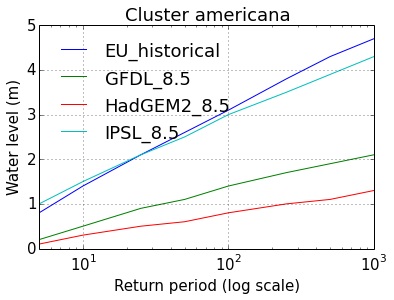

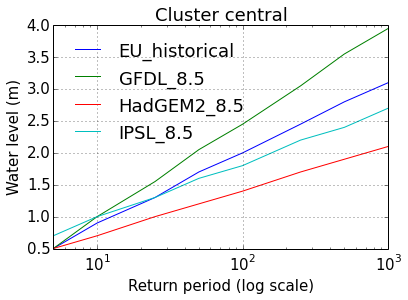

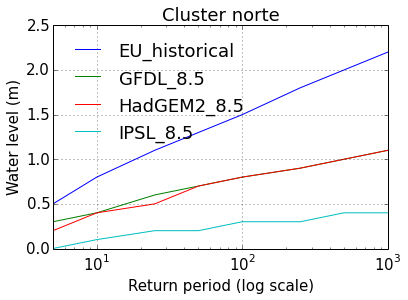

In [60]:
plot_water_level("americana")
plot_water_level("central")
plot_water_level("norte")

In [58]:
def steps(cm,redirection):
    if redirection==0:
        if cm<15:
            percent = 0
        elif (cm>=15)&(cm<25):
            percent = 0.3
        elif (cm>=25)&(cm<35):
            percent = 0.5
        elif (cm>=35)&(cm<60):
            percent = 0.7
        else:
            percent = 1
    elif redirection==1:
        if cm<10:
            percent = 0
        elif (cm>=10)&(cm<20):
            percent = 0.4
        elif (cm>=20)&(cm<30):
            percent = 0.6
        elif (cm>=30)&(cm<45):
            percent = 0.8
        else:
            percent = 1
    elif redirection==2:
        if cm<5:
            percent = 0
        elif (cm>=5)&(cm<10):
            percent = 0.5
        elif (cm>=10)&(cm<15):
            percent = 0.7
        elif (cm>=15)&(cm<30):
            percent = 0.9
        else:
            percent = 1
    return percent

In [17]:
from scipy.interpolate import InterpolatedUnivariateSpline
def days(length):
    s = InterpolatedUnivariateSpline([0, 5, 30, 50, 200, 300], [0,1*length,5*length,10*length,30*length,50*length], k=1)
    return s

In [37]:
costs_all[['scenarioID','CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL','SURFACE1','TERRAIN']]

,scenarioID,CLASS,COND1,Identifier,LANES,OPTIMAL,SURFACE1,TERRAIN
0,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating
1,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating
2,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating
3,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating
4,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating
5,central,Primary,Good,Carretera Central,6,1,Paved,Bendy and severely undulating
6,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating
7,norte,Primary,Good,Pan Americana,4,1,Paved,Mostly straight and gently undulating
